### CIFAR10 Dataset 생성

In [1]:
import numpy as np
import pandas as pd
import os

from keras.datasets import cifar10

In [2]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print("train dataset shape:", train_images.shape, train_labels.shape)
print("test dataset shape:", test_images.shape, test_labels.shape)

train dataset shape: (50000, 32, 32, 3) (50000, 1)
test dataset shape: (10000, 32, 32, 3) (10000, 1)


In [3]:
train_images[0, :, :, :], train_labels[0, :]

(array([[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],
 
        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],
 
        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],
 
        ...,
 
        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],
 
        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],
 
        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
  

In [4]:
NAMES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

### CIFAR10 데이터 시각화
- 32*32

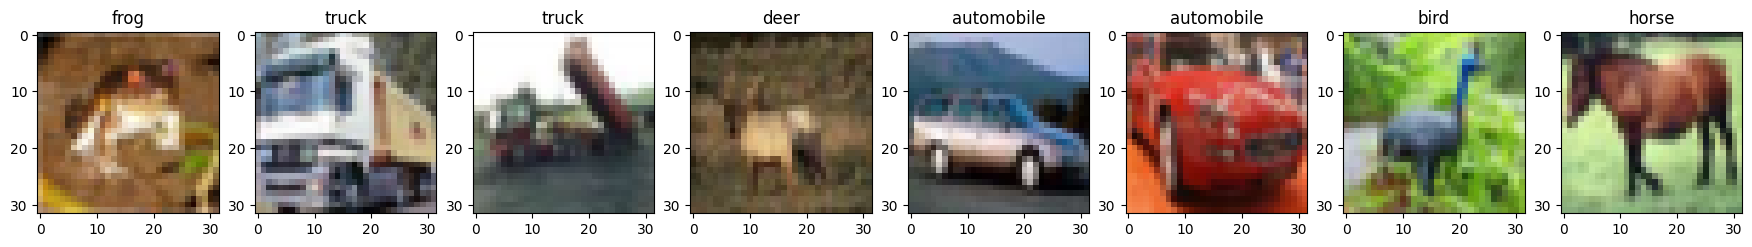

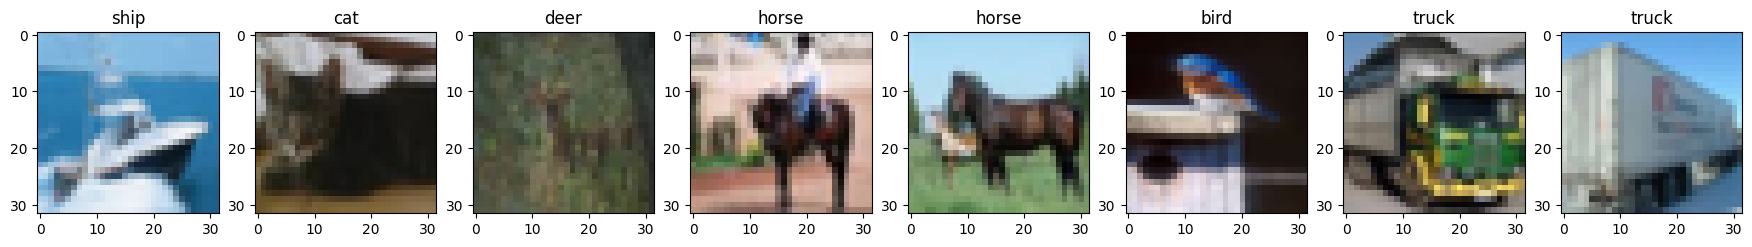

In [5]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
def show_images(images, labels, ncols=8):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i])
        label = labels[i].squeeze()
        axs[i].set_title(NAMES[int(label)])
        
show_images(train_images[:8], train_labels[:8], ncols=8)
show_images(train_images[8:16], train_labels[8:16], ncols=8)

### Data preprocessing

In [6]:
def get_preprocessed_data(images, labels):
    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형.
    # compile함수에서 loss = categorical_crossentropy일 경우 fit시점의 label값을 one-hot encoding된값으로 입력
    # compile함수에서 loss = sparse_categorical_crossentropy일 경우 fit시점의 label값을 Label Encoding된 값으로 입력
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    return images, labels
    
train_images, train_labels = get_preprocessed_data(train_images, train_labels)
test_images, test_labels = get_preprocessed_data(test_images, test_labels)

In [7]:
print(train_images.shape, train_labels.shape)

(50000, 32, 32, 3) (50000, 1)


In [8]:
train_labels = train_labels.squeeze()
test_labels = test_labels.squeeze()

In [9]:
train_labels, test_labels

(array([6., 9., 9., ..., 9., 1., 1.], dtype=float32),
 array([3., 8., 8., ..., 5., 1., 7.], dtype=float32))

### Custom Model 생성
<img src="b.jpg">

In [10]:
IMAGE_SIZE = 32

In [11]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam, RMSprop
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [12]:
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)

In [13]:
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', name='fc1')(x)
x = Dropout(rate=0.3)(x)

In [14]:
output = Dense(10, activation='softmax', name='output')(x)
model = Model(inputs=input_tensor, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0     

In [15]:
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(x=train_images, y=train_labels, batch_size=64, epochs=10, validation_split=0.15)

Epoch 1/10
665/665 [==============================] - 16s 20ms/step - loss: 1.6051 - accuracy: 0.4117 - val_loss: 1.2676 - val_accuracy: 0.5532
Epoch 2/10
665/665 [==============================] - 13s 19ms/step - loss: 1.1490 - accuracy: 0.5906 - val_loss: 1.0237 - val_accuracy: 0.6397
Epoch 3/10
665/665 [==============================] - 13s 19ms/step - loss: 0.9416 - accuracy: 0.6666 - val_loss: 0.7978 - val_accuracy: 0.7196
Epoch 4/10
665/665 [==============================] - 13s 19ms/step - loss: 0.8156 - accuracy: 0.7108 - val_loss: 0.7894 - val_accuracy: 0.7265
Epoch 5/10
665/665 [==============================] - 12s 19ms/step - loss: 0.7339 - accuracy: 0.7406 - val_loss: 0.8017 - val_accuracy: 0.7225
Epoch 6/10
665/665 [==============================] - 12s 18ms/step - loss: 0.6677 - accuracy: 0.7658 - val_loss: 0.6677 - val_accuracy: 0.7713
Epoch 7/10
665/665 [==============================] - 12s 18ms/step - loss: 0.6124 - accuracy: 0.7860 - val_loss: 0.6850 - val_accuracy:

313/313 [==============================] - 2s 5ms/step - loss: 0.6260 - accuracy: 0.7914


[0.6259534955024719, 0.7914000153541565]

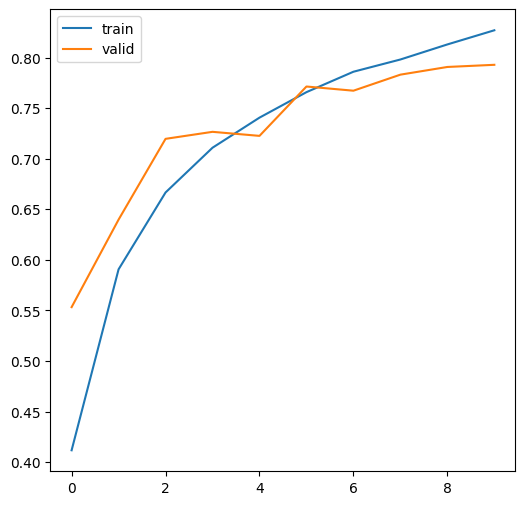

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
show_history(history)
# 테스트 데이터로 성능 평가
model.evaluate(test_images, test_labels)

In [18]:
preds = model.predict(np.expand_dims(test_images[0], axis=0))

1/1 [==============================] - 0s 228ms/step


In [19]:
print('예측 결과 shape:', preds.shape)
print('예측 결과:', preds)
preds.argmax()

preds = model.predict(test_images[:32], batch_size=32)
print('예측 결과 shape:', preds.shape)
print('예측 결과:', preds)

예측 결과 shape: (1, 10)
예측 결과: [[7.8054797e-04 7.4236006e-05 1.7460434e-04 9.5179856e-01 1.3625778e-05
  1.8842071e-02 1.7983919e-02 1.2630221e-04 8.9940606e-03 1.2121013e-03]]
1/1 [==============================] - 0s 19ms/step
예측 결과 shape: (32, 10)
예측 결과: [[7.80550123e-04 7.42362827e-05 1.74604487e-04 9.51798439e-01
  1.36257895e-05 1.88420285e-02 1.79838650e-02 1.26302082e-04
  8.99409410e-03 1.21210865e-03]
 [2.33573573e-05 4.42522531e-03 5.04874059e-11 3.34198536e-09
  3.95986412e-14 1.56058651e-13 1.06257869e-09 4.93464210e-13
  9.95542943e-01 8.45536124e-06]
 [6.28136704e-03 9.19339359e-02 2.73628871e-06 2.63368507e-04
  2.47679139e-07 1.13222507e-06 4.10934854e-06 8.82914264e-06
  8.92838538e-01 8.66584387e-03]
 [8.02321553e-01 5.60132576e-05 9.35441421e-05 1.16723440e-05
  1.87274982e-05 1.78076807e-08 1.10018823e-06 4.60449723e-09
  1.97472543e-01 2.47792595e-05]
 [3.07644186e-08 1.62279825e-08 2.73903962e-02 2.77891941e-02
  3.13828550e-02 1.29689161e-05 9.13424253e-01 1.432794

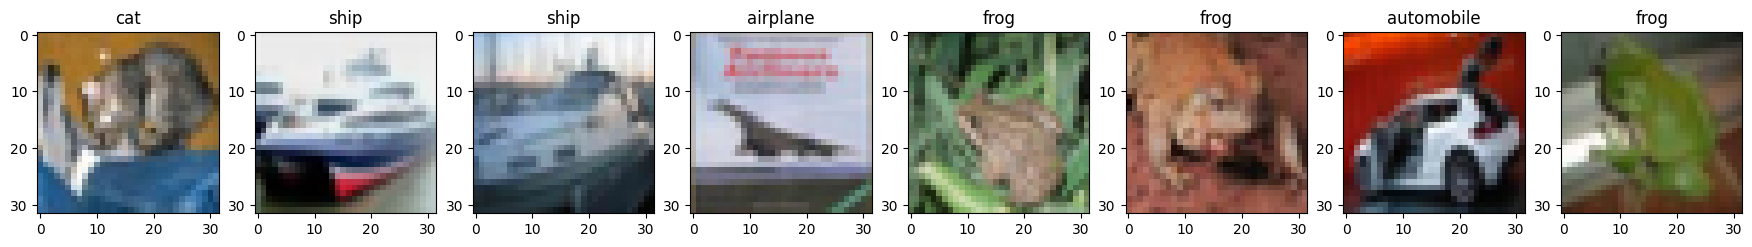

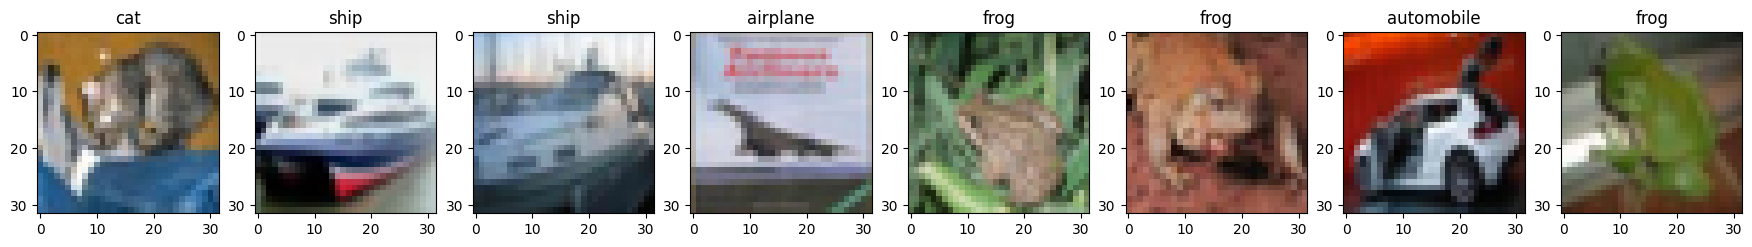

In [20]:
predicted_class = np.argmax(preds, axis=1)
show_images(test_images[:8], predicted_class[:8], ncols=8)
show_images(test_images[:8], test_labels[:8], ncols=8)